In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate noisy sine wave data
n = 2000
x_data = np.linspace(-7, 7, num=n)
y_data = np.sin(x_data) + 0.1 * np.random.normal(size=n)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


In [3]:
# Define the model without Dropout for uncertainty estimation before Monte Carlo Dropout
model_no_dropout = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='linear')
])

# Compile the model
model_no_dropout.compile(optimizer='adam', loss='mean_squared_error')

# Train the model without Dropout
model_no_dropout.fit(x_train, y_train, epochs=100, verbose=0)

In [4]:
# Calculate predictions and uncertainty before Monte Carlo Dropout
predictions_before_dropout = model_no_dropout.predict(x_test)
uncertainty_before_dropout = np.std(predictions_before_dropout, axis=0)
print("uncertainty before dropout: ", uncertainty_before_dropout)

13/13 [==============================] - 0s 2ms/step
uncertainty before dropout:  [0.5637933]


In [5]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [6]:
# Define the model with Monte Carlo Dropout
model = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    MCDropout(0.15),
    Dense(32, activation='relu'),
    MCDropout(0.15),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=100, verbose=0)

In [7]:
# Define the Monte Carlo Dropout prediction function
def monte_carlo_dropout(x, model, dropout_rate, n_samples):
    predictions = []
    for _ in range(n_samples):
        predictions.append(model.predict(x))
    return np.array(predictions)

In [8]:
# Monte Carlo Dropout uncertainty estimation
dropout_rate = 0.15
n_samples = 1600

# Predict on test set with Monte Carlo Dropout
predictions_after_dropout = monte_carlo_dropout(x_test, model, dropout_rate, n_samples)
uncertainty_after_dropout = np.std(predictions_after_dropout, axis=0)

# Reshape arrays to 1-dimensional
mean_predictions = np.squeeze(np.mean(predictions_after_dropout, axis=0))
uncertainty_after_dropout = np.squeeze(uncertainty_after_dropout)

print("uncertainty after dropout: ", min(uncertainty_after_dropout))

13/13 [==============================] - 0s 1ms/step
uncertainty after dropout:  0.1460521


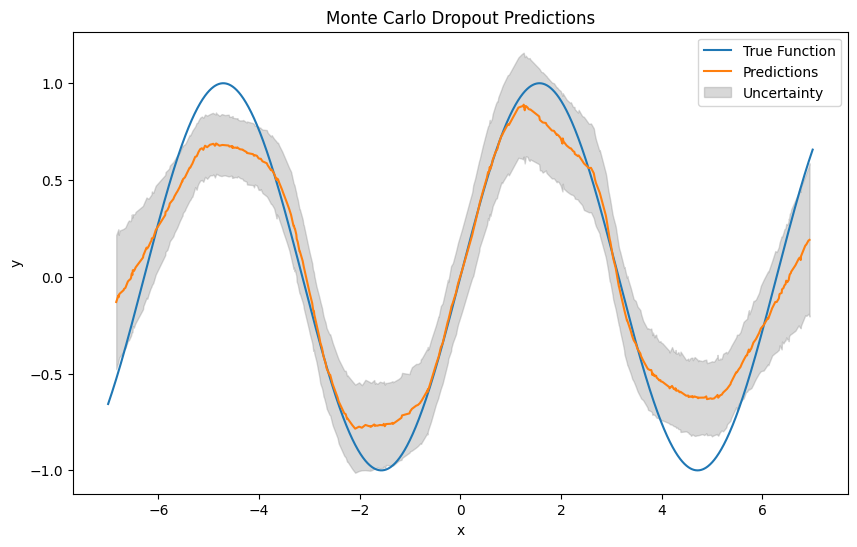

In [9]:
sorted_indices = x_test.argsort()
x_test_sorted = x_test[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
uncertainty_after_dropout_sorted = uncertainty_after_dropout[sorted_indices]

y_upper = mean_predictions_sorted + uncertainty_after_dropout_sorted
y_lower = mean_predictions_sorted - uncertainty_after_dropout_sorted

plt.figure(figsize=(10, 6))
plt.plot(x_data, np.sin(x_data), label='True Function')
plt.plot(x_test_sorted, mean_predictions_sorted, label='Predictions')
plt.fill_between(x_test_sorted, y_lower, y_upper, color='gray', alpha=0.3, label='Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Monte Carlo Dropout Predictions')
plt.legend()
plt.show()

